In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, GRU, Bidirectional, LSTM
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error
import keras

Using TensorFlow backend.


In [2]:
# Read data from csv file, consider column 'date' as index and parse it into date object
dataset = pd.read_csv('../input/historical_stock_prices.csv', index_col='date', parse_dates=['date'])

In [3]:
# Selecting training_set from begining of 2015 till end of 2017, we can do this because our index in date object
# and selecting test_set from begining of 2018 onwards
trainSet = dataset['2015':'2017'].sort_values(by=['ticker','date'])
testSet = dataset['2018':].sort_values(by=['ticker','date'])

# Normalize each symbols independently

In [36]:
symbols = trainSet.ticker.unique()
print(symbols)

['A' 'AA' 'AABA' ... 'ZUMZ' 'ZYME' 'ZYNE']


In [5]:
timesteps = 60
def make_samples(data, s, is_test):
    stop_append = {}
    for i in prediction_intervals:
        stop_append.update({i:False}) 
    l = len(data)
    for i in range(timesteps, l):
        x = data[i-timesteps: i, 0]
        for j in stop_append:
            if not stop_append[j]:
                if i+j-1 < l:
                    k = data[i+j-1,0]
                    if is_test:
                        test_set[s]['X'][j].append(x)
                        test_set[s]['Y'][j].append(k)
                    else:
                        train_set[s]['X'][j].append(x)
                        train_set[s]['Y'][j].append(k)
                    if k == data[l-1,0]:
                        stop_append[j] =True

In [6]:
test_set = {}
train_set = {}
scaler = {}
prediction_intervals = [1,3,5,10]
for s in symbols:
    # normalize data
    sc = MinMaxScaler(feature_range=(0,1))     
    train_stock = trainSet.loc[trainSet['ticker'] == s][['adj_close']].values
    test_stock = testSet.loc[testSet['ticker'] == s][['adj_close']].values
    sc.partial_fit(train_stock)
    if len(test_stock):
        sc.partial_fit(test_stock)
        test_stock_scaled = sc.transform(test_stock)
    train_stock_scaled = sc.transform(train_stock)
    scaler[s] = sc
    
    # Define train_set test_set
    train_set.update({s:{
        'X':{},
        'Y':{}
    }})
    test_set.update({s:{
        'X':{},
        'Y':{}
    }})
    for i in prediction_intervals:
        train_set[s]['X'][i] = []
        train_set[s]['Y'][i] = []
        if len(test_stock):
            test_set[s]['X'][i] = []
            test_set[s]['Y'][i] = []
    if len(test_stock):
        make_samples(test_stock_scaled, s, is_test = True)
    make_samples(train_stock_scaled, s, is_test = False)

In [7]:
# Convert into numpy array
for s in train_set:
    for i in train_set[s]['X']:
        x_train = train_set[s]['X'][i]
        y_train = train_set[s]['Y'][i]
        train_set[s]['X'][i] = np.array(x_train)
        train_set[s]['Y'][i] = np.array(y_train)
    for i in test_set[s]['X']:
        x_test = test_set[s]['X'][i]
        y_test = test_set[s]['Y'][i]
        test_set[s]['X'][i] = np.array(x_test)
        test_set[s]['Y'][i] = np.array(y_test)

In [8]:
np.save('train_set.npy', train_set) 
np.save('test_set.npy', test_set)

In [9]:
# Callback function `earlystopping` to trigger while training it monitor 'loss'
# start from first epoch it record min value of loss and if model can not find 
# lower loss value in next 3 epochs model will stop training.
es = keras.callbacks.EarlyStopping(monitor='val_loss',patience=2, mode='min')

In [10]:
# The GRU architecture
# We are using Sequential model of Keras
# Our hidden layer using activation = 'tanh' and having 50 neurons each layer
# The output layer of fully connected layer is having only 1 neurons because we want only one output value
def make_gru_network():
    regressorGRU = Sequential()
    # First GRU layer with Dropout regularisation
    
    regressorGRU.add(GRU(units=30, input_shape=(60,1), activation='tanh'))
    regressorGRU.add(Dropout(0.3))
    
    # The output layer
    regressorGRU.add(Dense(units=1))
    return regressorGRU

In [11]:
model = {}
model_history = {}
for i in prediction_intervals:
    model[i] = make_gru_network()
    model[i].compile(optimizer='rmsprop', loss='mean_squared_error')
    n_epoch = 100
    x_train = []
    y_train = []
    for s in train_set:
        for j in train_set[s]['X'][i]:
            x_train.append(j)
        for j in train_set[s]['Y'][i]:
            y_train.append(j)
    X_train, Y_train = np.array(x_train), np.array(y_train)
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    
    print('Fitting prediction interval {}  model'.format(i))
    model_history[i] = model[i].fit(X_train, Y_train, epochs = n_epoch, batch_size = 6000, 
                                    validation_split = 0.3,callbacks=[es])

Fitting prediction interval 1  model
Train on 2187684 samples, validate on 937579 samples
Epoch 1/100
2187684/2187684 [==============================] - 58s 26us/step - loss: 0.0110 - val_loss: 9.6044e-04
Epoch 2/100
2187684/2187684 [==============================] - 54s 25us/step - loss: 0.0025 - val_loss: 7.5281e-04
Epoch 3/100
2187684/2187684 [==============================] - 54s 25us/step - loss: 0.0019 - val_loss: 7.8588e-04
Epoch 4/100
2187684/2187684 [==============================] - 257s 117us/step - loss: 0.0017 - val_loss: 6.7779e-04
Epoch 5/100
2187684/2187684 [==============================] - 47s 21us/step - loss: 0.0016 - val_loss: 6.8852e-04
Epoch 6/100
2187684/2187684 [==============================] - 47s 21us/step - loss: 0.0016 - val_loss: 7.1698e-04
Fitting prediction interval 3  model
Train on 2180201 samples, validate on 934372 samples
Epoch 1/100
2180201/2180201 [==============================] - 48s 22us/step - loss: 0.0073 - val_loss: 0.0019
Epoch 2/100
21802

In [33]:
for i in prediction_intervals:
    model[i].save('gru_model_{}.h5'.format(i))

## Loss Graph

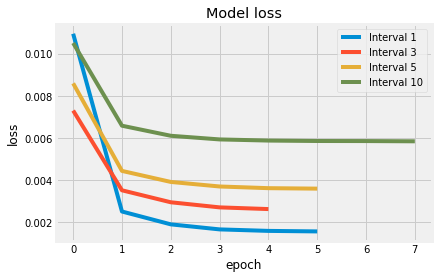

In [12]:
for i in prediction_intervals:
    plt.plot(model_history[i].history['loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Interval 1', 'Interval 3', 'Interval 5', 'Interval 10'], loc='upper right')
plt.show()

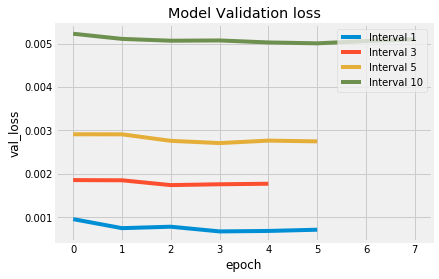

In [13]:
for i in prediction_intervals:
    plt.plot(model_history[i].history['val_loss'])
plt.title('Model Validation loss')
plt.ylabel('val_loss')
plt.xlabel('epoch')
plt.legend(['Interval 1', 'Interval 3', 'Interval 5', 'Interval 10'], loc='upper right')
plt.show()

## Helper function ##

In [14]:
# Calculate Mean squared_error #
def return_mse(test,predicted):
    mse = mean_squared_error(test, predicted)
    return mse

In [15]:
# Plotting graph
def plotting_graph(y_test, y_pred, ticker, des):
    plt.plot(y_test, color='green', label='Actual adj_close value')
    plt.plot(y_pred, color='red', label='Predicted adj_close value')
    plt.title('Prediction of {} on {}'.format(ticker, des))
    plt.xlabel('Time steps')
    plt.ylabel('adj_close value')
    plt.legend()
    plt.show()

# Evaluate model #

In [16]:

def make_prediction(data, s, i):
    sc = scaler[s]
    mse = 0
    # Define X_test
    x_test = data[s]['X'][i]
    X_test = np.array(x_test)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    # Define y_true
    y_test = data[s]['Y'][i]
    Y_test = np.array(y_test)
    Y_test = Y_test.reshape(-1,1)
    y_true = sc.inverse_transform(Y_test)

    # Predicting
    result = model[i].predict(X_test)
    y_pred = sc.inverse_transform(result)

    # Calculate MSE
    mse = return_mse(y_true, y_pred)
    return y_true, y_pred, mse

## Predicting on Train Set

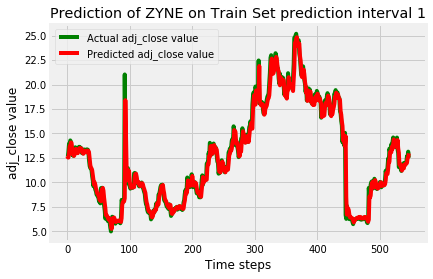

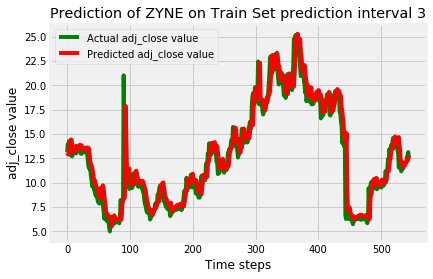

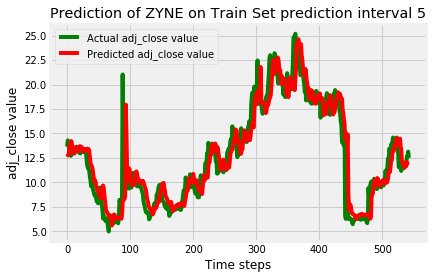

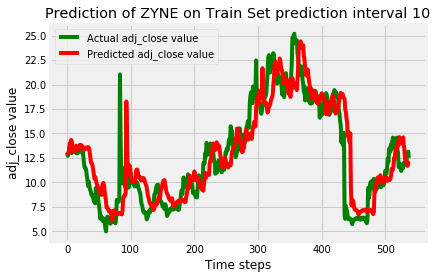

In [37]:
mse_val = {}
for i in prediction_intervals:
    # Predicting
    s = 'ZYNE'
    y_true, y_pred, mse = make_prediction(train_set, s, i)
    mse_val[i] = mse
    # Plotting graph
    plotting_graph(y_true, y_pred, s, 'Train Set prediction interval {}'.format(i))

In [38]:
for i in mse_val:
    print('Train Set -> MSE of {} inveral {}: {}'.format(s, i, mse_val[i]))

Train Set -> MSE of ZYNE inveral 1: 0.872482908783664
Train Set -> MSE of ZYNE inveral 3: 2.0019622860222874
Train Set -> MSE of ZYNE inveral 5: 2.8501551751871523
Train Set -> MSE of ZYNE inveral 10: 6.015052299782491


## Predicting on Test Set

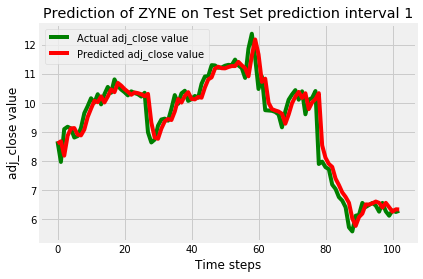

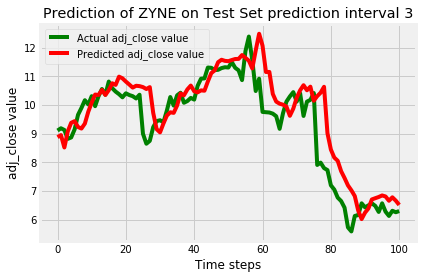

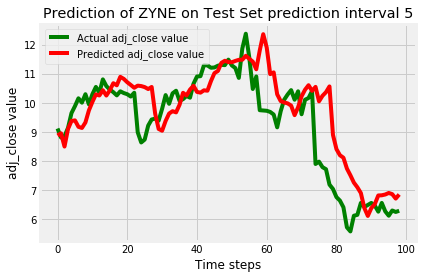

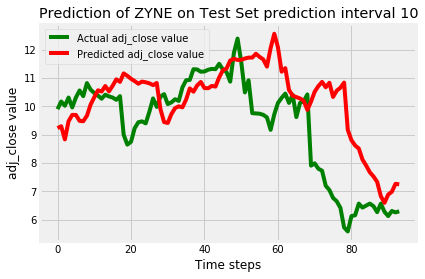

In [39]:
mse_val = {}
for i in prediction_intervals:
    # Predicting
    s = 'ZYNE'
    y_true, y_pred, mse = make_prediction(test_set, s, i)
    mse_val[i] = mse
    # Plotting graph
    plotting_graph(y_true, y_pred, s, 'Test Set prediction interval {}'.format(i))

In [40]:
for i in mse_val:
    print('Test Set -> MSE of {} inveral {}: {}'.format(s, i, mse_val[i]))

Test Set -> MSE of ZYNE inveral 1: 0.21256051658551978
Test Set -> MSE of ZYNE inveral 3: 0.6998187835585465
Test Set -> MSE of ZYNE inveral 5: 1.0794223331003
Test Set -> MSE of ZYNE inveral 10: 2.7144182344438827
